<a href="https://colab.research.google.com/github/itzThillaiC/Astronomical-image-denoiser/blob/main/SRGAN_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Importing the required packages

In [ ]:
import os
import random
import torch
import torch.nn as n
import torch.nn.functional as f
import numpy as np
import os
from torchsummary import summary
import torch.optim as optim
from tqdm import tqdm
from torchvision import models
import cv2
from matplotlib import pyplot as plt
from PIL import Image

In [ ]:
IMAGES_PATH = '/content/drive/My Drive/Galaxy10/'
IMAGES = os.listdir(IMAGES_PATH)
random.shuffle(IMAGES)

In [ ]:
len(IMAGES)

503

Assigning the device as cuda if GPU is available else cpu

In [ ]:
cuda = torch.device("cuda" if torch.cuda.is_available() else "cpu") 

Defining the generator architecture as given the reference paper

In [ ]:
class Generator(n.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = n.Conv2d(3,64,9,padding=4,bias=False)
        self.conv2 = n.Conv2d(64,64,3,padding=1,bias=False)
        self.conv3_1 = n.Conv2d(64,256,3,padding=1,bias=False)
        self.conv3_2 = n.Conv2d(64,256,3,padding=1,bias=False)
        self.conv4 = n.Conv2d(64,3,9,padding=4,bias=False)
        self.bn = n.BatchNorm2d(64)
        self.ps = n.PixelShuffle(2)
        self.prelu = n.PReLU()
        
    def forward(self,x):
        block1 = self.prelu(self.conv1(x))
        block2 = torch.add(self.bn(self.conv2(self.prelu(self.bn(self.conv2(block1))))),block1)
        block3 = torch.add(self.bn(self.conv2(self.prelu(self.bn(self.conv2(block2))))),block2)
        block4 = torch.add(self.bn(self.conv2(self.prelu(self.bn(self.conv2(block3))))),block3)
        block5 = torch.add(self.bn(self.conv2(self.prelu(self.bn(self.conv2(block4))))),block4)
        block6 = torch.add(self.bn(self.conv2(self.prelu(self.bn(self.conv2(block5))))),block5)
        block7 = torch.add(self.bn(self.conv2(block6)),block1)
        block8 = self.prelu(self.ps(self.conv3_1(block7)))
        block9 = self.prelu(self.ps(self.conv3_2(block8)))
        block10 = self.conv4(block9)
        return block10

Assigning the Generator to cuda(if available) and printing the summary of the Generator with a dummy input

In [ ]:
gen = Generator().to(cuda)

#Uncomment below mentioned three lines if you have more than one gpu and want to use all of them
#ngpu=2
# if (cuda.type == 'cuda') and (ngpu > 1):
#     gen = n.DataParallel(gen, list(range(ngpu)))
summary(gen,(3,64,64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 64, 64]          15,552
             PReLU-2           [-1, 64, 64, 64]               1
            Conv2d-3           [-1, 64, 64, 64]          36,864
       BatchNorm2d-4           [-1, 64, 64, 64]             128
             PReLU-5           [-1, 64, 64, 64]               1
            Conv2d-6           [-1, 64, 64, 64]          36,864
       BatchNorm2d-7           [-1, 64, 64, 64]             128
            Conv2d-8           [-1, 64, 64, 64]          36,864
       BatchNorm2d-9           [-1, 64, 64, 64]             128
            PReLU-10           [-1, 64, 64, 64]               1
           Conv2d-11           [-1, 64, 64, 64]          36,864
      BatchNorm2d-12           [-1, 64, 64, 64]             128
           Conv2d-13           [-1, 64, 64, 64]          36,864
      BatchNorm2d-14           [-1, 64,

Defining the Discriminator network as given in the reference paper expect that a dropout in the last layer

In [ ]:
class Discriminator(n.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = n.Conv2d(3,64,3,padding=1,bias=False)
        self.conv2 = n.Conv2d(64,64,3,stride=2,padding=1,bias=False)
        self.bn2 = n.BatchNorm2d(64)
        self.conv3 = n.Conv2d(64,128,3,padding=1,bias=False)
        self.bn3 = n.BatchNorm2d(128)
        self.conv4 = n.Conv2d(128,128,3,stride=2,padding=1,bias=False)
        self.bn4 = n.BatchNorm2d(128)
        self.conv5 = n.Conv2d(128,256,3,padding=1,bias=False)
        self.bn5 = n.BatchNorm2d(256)
        self.conv6 = n.Conv2d(256,256,3,stride=2,padding=1,bias=False)
        self.bn6 = n.BatchNorm2d(256)
        self.conv7 = n.Conv2d(256,512,3,padding=1,bias=False)
        self.bn7 = n.BatchNorm2d(512)
        self.conv8 = n.Conv2d(512,512,3,stride=2,padding=1,bias=False)
        self.bn8 = n.BatchNorm2d(512)
        self.fc1 = n.Linear(512*16*16,1024)
        self.fc2 = n.Linear(1024,1)
        self.drop = n.Dropout2d(0.3)
        
    def forward(self,x):
        block1 = f.leaky_relu(self.conv1(x))
        block2 = f.leaky_relu(self.bn2(self.conv2(block1)))
        block3 = f.leaky_relu(self.bn3(self.conv3(block2)))
        block4 = f.leaky_relu(self.bn4(self.conv4(block3)))
        block5 = f.leaky_relu(self.bn5(self.conv5(block4)))
        block6 = f.leaky_relu(self.bn6(self.conv6(block5)))
        block7 = f.leaky_relu(self.bn7(self.conv7(block6)))
        block8 = f.leaky_relu(self.bn8(self.conv8(block7)))
        block8 = block8.view(-1,block8.size(1)*block8.size(2)*block8.size(3))
        block9 = f.leaky_relu(self.fc1(block8),)
#         block9 = block9.view(-1,block9.size(1)*block9.size(2)*block9.size(3))
        block10 = torch.sigmoid(self.drop(self.fc2(block9)))
        return block9,block10

Assigning the discriminator to the gpu(if available) and printing the summary of the network with a dummy value

In [ ]:
disc = Discriminator().to(cuda)
summary(disc,(3,256,256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 256, 256]           1,728
            Conv2d-2         [-1, 64, 128, 128]          36,864
       BatchNorm2d-3         [-1, 64, 128, 128]             128
            Conv2d-4        [-1, 128, 128, 128]          73,728
       BatchNorm2d-5        [-1, 128, 128, 128]             256
            Conv2d-6          [-1, 128, 64, 64]         147,456
       BatchNorm2d-7          [-1, 128, 64, 64]             256
            Conv2d-8          [-1, 256, 64, 64]         294,912
       BatchNorm2d-9          [-1, 256, 64, 64]             512
           Conv2d-10          [-1, 256, 32, 32]         589,824
      BatchNorm2d-11          [-1, 256, 32, 32]             512
           Conv2d-12          [-1, 512, 32, 32]       1,179,648
      BatchNorm2d-13          [-1, 512, 32, 32]           1,024
           Conv2d-14          [-1, 512,

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1320: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


In [ ]:
disc = Discriminator().to(cuda).float()
gen = Generator().to(cuda).float()

Downloading the pretrained vgg19 model from model module of torchvision library

In [ ]:
vgg = models.vgg19(pretrained=True).to(cuda)

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


  0%|          | 0.00/548M [00:00<?, ?B/s]

Defining the losses to be used in training

In [ ]:
gen_loss = n.BCELoss()
vgg_loss = n.MSELoss()
mse_loss = n.MSELoss()
disc_loss = n.BCELoss()

Defining the adam optimizers for generator and discriminator

In [ ]:
gen_optimizer = optim.Adam(gen.parameters(),lr=0.0001)
disc_optimizer = optim.Adam(disc.parameters(),lr=0.0001)

Loading the images after based on resizing as numpy array

In [ ]:
def loadImages(IMAGES,path,resize=False):
    images=[]
    for image in (IMAGES):
#         print(image)
        if resize:
            img = cv2.resize(cv2.imread(os.path.join(path,image)),(256,256)) 
        else:
            img = cv2.imread(os.path.join(path,image))
#         img = img.reshape(img.shape[2],img.shape[0],img.shape[1])
#         print(img.shape)
        img = np.moveaxis(img, 2, 0)
#         print(img.shape)
        images.append(img)
    return np.array(images)

Converting the high resolution images into low resolution by applying gaussian blur, resizing in to 64*64 and loading it as numpy array

In [ ]:
def loadLRImages(IMAGES,path):
    images=[]
    for image in (IMAGES):
        img = cv2.resize(cv2.GaussianBlur(cv2.imread(os.path.join(path,image)),(5,5),cv2.BORDER_DEFAULT),(64,64)) 
#         img = img.reshape(img.shape[2],img.shape[0],img.shape[1])
        img = np.moveaxis(img, 2, 0)
        images.append(img)
    return np.array(images)

Loading the generator model from the given checkpoint

In [ ]:
def load_checkpoint(filepath):
    checkpoint = torch.load(filepath)
    model = checkpoint['model']
    model.load_state_dict(checkpoint['state_dict'])
    for parameter in model.parameters():
        parameter.requires_grad = False
    
    model.eval()
    
    return model

Given low resolution images and checkpoint, Generating the high resolution images out of it 

In [ ]:
def imagePostProcess(imagedir,modelPath):
    imagelist=[]
#     images = os.listdir(imagedir)
    for img in imagedir:
        img = cv2.resize(cv2.GaussianBlur(cv2.imread(os.path.join(hr_path,img)),(5,5),cv2.BORDER_DEFAULT),(64,64)) 
        imagelist.append(img)
    imagearray = np.array(imagelist)/255
#     imagearray = (imagedir)/255
    # imagearrayPT = np.reshape(imagearray,(len(imagelist),imagearray.shape[3],imagearray.shape[1],imagearray.shape[2]))
    imagearrayPT = np.moveaxis(imagearray,3,1)
    # print(imagearrayPT.shape)

    model = load_checkpoint(modelPath)
    im_tensor = torch.from_numpy(imagearrayPT).float()
    out_tensor = model(im_tensor)
    # print(out_tensor.shape)
    # out = np.reshape(out_tensor,[out_tensor.shape[0],out_tensor.shape[2],out_tensor.shape[3],out_tensor.shape[1]])
    out = out_tensor.numpy()
    out = np.moveaxis(out,1,3)
    # print(out.shape)
    out = np.clip(out,0,1)
    
    return out

Display utility of displaying images using matplotlib

In [ ]:
def show_samples(sample_images):
    figure, axes = plt.subplots(1, sample_images.shape[0], figsize = (10,10))
    for index, axis in enumerate(axes):
        axis.axis('off')
        image_array = sample_images[index]
        axis.imshow(image_array)
        image = Image.fromarray((image_array * 255).astype('uint8'))
    plt.savefig(os.path.join(base_path,"out/SR")+"_"+str(epoch)+".png", bbox_inches='tight', pad_inches=0)
    plt.show()
    plt.close()

In [ ]:
#change the batch-size based on your system memory

epochs=10
batch_size=5

In [ ]:
import os 
base_path = os.getcwd()

#lr_path = os.path.join(base_path,"trainImages")
hr_path =IMAGES_PATH
#valid_path = os.path.join(base_path,"SR_valid")
weight_file = os.path.join(base_path,"SRPT_weights")
out_path = os.path.join(base_path,"out")

if not os.path.exists(weight_file):
    os.makedirs(weight_file)

if not os.path.exists(out_path):
    os.makedirs(out_path)

    
#LR_images_list = os.listdir(lr_path)
HR_images_list = IMAGES
batch_count = len(HR_images_list)//batch_size
batch_count

15

Starting of training and defining losses

  0%|          | 0/60 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1320: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)
100%|██████████| 60/60 [01:14<00:00,  1.24s/it]


Epoch ::::  1  d1_loss ::: 0.21694811403751893  d2_loss :::0.21786870410044987
genLoss ::: 41.198015467325845  vggLoss ::: 0.02088410980068147  MeanLoss  ::: 0.0011972981204356377


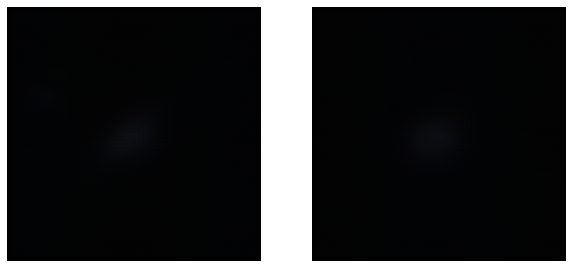

100%|██████████| 60/60 [01:13<00:00,  1.23s/it]


Epoch ::::  2  d1_loss ::: 0.20813550899426142  d2_loss :::0.42131578765499095
genLoss ::: 55.790312671661376  vggLoss ::: 0.01986700833464662  MeanLoss  ::: 0.0011320665609673597


100%|██████████| 60/60 [01:13<00:00,  1.23s/it]


Epoch ::::  3  d1_loss ::: 0.5905928593572753  d2_loss :::0.20362834334373475
genLoss ::: 53.38950090408325  vggLoss ::: 0.01928901826031506  MeanLoss  ::: 0.00107066566318584


100%|██████████| 60/60 [01:13<00:00,  1.23s/it]


Epoch ::::  4  d1_loss ::: 0.16773605744043987  d2_loss :::0.22411758899688722
genLoss ::: 67.34873905181885  vggLoss ::: 0.01891872179694474  MeanLoss  ::: 0.0010120549394438663


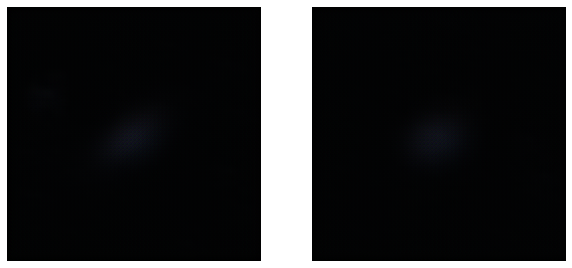

100%|██████████| 60/60 [01:14<00:00,  1.24s/it]


Epoch ::::  5  d1_loss ::: 0.208510243644317  d2_loss :::0.2395939936240514
genLoss ::: 50.92604532241821  vggLoss ::: 0.018641444761306046  MeanLoss  ::: 0.0009490861460411301


100%|██████████| 60/60 [01:14<00:00,  1.23s/it]


Epoch ::::  6  d1_loss ::: 0.19177072097857792  d2_loss :::0.20563366413116455
genLoss ::: 69.74101521174113  vggLoss ::: 0.018409485664839544  MeanLoss  ::: 0.0008770589711881864


100%|██████████| 60/60 [01:13<00:00,  1.23s/it]


Epoch ::::  7  d1_loss ::: 0.22642807960510253  d2_loss :::0.1802182674407959
genLoss ::: 65.5763825416565  vggLoss ::: 0.01820731214247644  MeanLoss  ::: 0.0008183535513429282


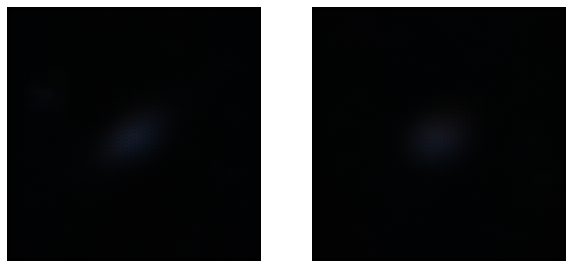

100%|██████████| 60/60 [01:13<00:00,  1.23s/it]


Epoch ::::  8  d1_loss ::: 0.20563366413116455  d2_loss :::0.21025464534759522
genLoss ::: 67.98766187032064  vggLoss ::: 0.01802801719556252  MeanLoss  ::: 0.0007793914002832026


100%|██████████| 60/60 [01:13<00:00,  1.23s/it]


Epoch ::::  9  d1_loss ::: 0.1871497392654419  d2_loss :::0.22180709838867188
genLoss ::: 69.71880280176798  vggLoss ::: 0.01787171852774918  MeanLoss  ::: 0.0007469921392233421


100%|██████████| 60/60 [01:13<00:00,  1.23s/it]


Epoch ::::  10  d1_loss ::: 0.23104912241299946  d2_loss :::0.20563366413116455
genLoss ::: 62.424197896321616  vggLoss ::: 0.017733025675018627  MeanLoss  ::: 0.0007134066060340653


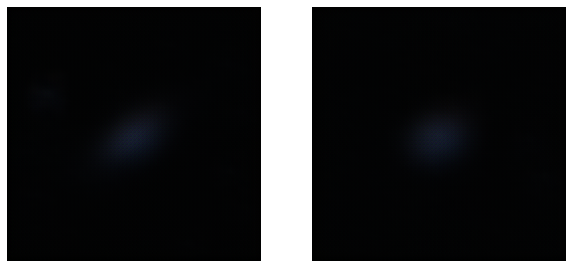

In [ ]:
batch_count=60
import torch
torch.cuda.empty_cache()
for epoch in range(epochs):
    d1loss_list=[]
    d2loss_list=[]
    gloss_list=[]
    vloss_list=[]
    mloss_list=[]
     

    
    for batch in tqdm(range(batch_count)):
        hr_imagesList = [img for img in HR_images_list[batch*batch_size:(batch+1)*batch_size]]
        lr_images = loadLRImages(hr_imagesList,hr_path)/255
        hr_images = loadImages(hr_imagesList,hr_path,True)/255
        
                
        disc.zero_grad()

        gen_out = gen(torch.from_numpy(lr_images).to(cuda).float())
        _,f_label = disc(gen_out)
        _,r_label = disc(torch.from_numpy(hr_images).to(cuda).float())
        d1_loss = (disc_loss(f_label,torch.zeros_like(f_label,dtype=torch.float)))
        d2_loss = (disc_loss(r_label,torch.ones_like(r_label,dtype=torch.float)))
        # d_loss = d1_loss+d2_loss
        d2_loss.backward()
        d1_loss.backward(retain_graph=True)
        # print(d1_loss,d2_loss)
#         d_loss.backward(retain_graph=True)
        disc_optimizer.step()
        

        gen.zero_grad()      
        g_loss = gen_loss(f_label.data,torch.ones_like(f_label,dtype=torch.float))
        v_loss = vgg_loss(vgg.features[:7](gen_out),vgg.features[:7](torch.from_numpy(hr_images).to(cuda).float()))
        m_loss = mse_loss(gen_out,torch.from_numpy(hr_images).to(cuda).float())
        
        generator_loss = g_loss + v_loss + m_loss
        # v_loss.backward(retain_graph=True)
        # m_loss.backward(retain_graph=True)
        # g_loss.backward()
        # print(generator_loss)

        generator_loss.backward()
        gen_optimizer.step()
        
        d1loss_list.append(d1_loss.item())
        d2loss_list.append(d2_loss.item())
        
        gloss_list.append(g_loss.item())
        vloss_list.append(v_loss.item())
        mloss_list.append(m_loss.item())

        
        
#         print("d1Loss ::: "+str((d1_loss.item()))+" d2Loss ::: "+str((d2_loss.item())))
#         print("gloss ::: "+str((g_loss.item()))+" vloss ::: "+str((v_loss.item()))+" mloss ::: "+str((m_loss.item())))
    print("Epoch ::::  "+str(epoch+1)+"  d1_loss ::: "+str(np.mean(d1loss_list))+"  d2_loss :::"+str(np.mean(d2loss_list)))
    print("genLoss ::: "+str(np.mean(gloss_list))+"  vggLoss ::: "+str(np.mean(vloss_list))+"  MeanLoss  ::: "+str(np.mean(mloss_list)))
    
    if(epoch%3==0):
        
        checkpoint = {'model': Generator(),
              'input_size': 64,
              'output_size': 256,
              'state_dict': gen.state_dict()}
        torch.save(checkpoint,os.path.join(weight_file,"SR"+str(epoch+1)+".pth"))
        torch.cuda.empty_cache()
        
        out_images = imagePostProcess(IMAGES[-2:],os.path.join(weight_file,"SR"+str(epoch+1)+".pth"))
#         print(out_images.shape)
#         test_images = loadLRImages(images[:-3],hr_path)/255
#         test_images = np.reshape(test_images,(test_images[0],test_images.shape[3],test_images.shape[1],test_images.shape[2]))
#         out_images = gen(torch.from_numpy(test_images).to(cuda).float())
#         out_images = np.reshape(out_images,(out_images[0],out_images[2],out_images[3],out_images[1]))
        show_samples(out_images)
        